In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVCal
from pyuvdata import UVData
import glob
import aipy
from hera_qm import ant_metrics
from hera_cal import omni, utils, firstcal
from matplotlib.colors import LogNorm
import sys
from copy import deepcopy
import omnical
%matplotlib inline 

# Data location

In [2]:
pols = ['xx','xy','yx','yy']
antpols = ['x','y']
origin = '/lustre/aoc/projects/hera/zali/HERA2015/'
time = '2457555.42443'
day = time.split('.')[0]
dataFileList = [origin + day + '/zen.' + time + '.' + pol + '.HH.uvc' for pol in pols]
ant_metrics_json = origin + day + '/IDR3/zen.' + time + '.HH.uvc.ant_metrics.json'
fcFileList = [origin + day + '/IDR3/zen.' + time + '.' + pol + '.HH.uvc.first.calfits' for pol in [pols[0],pols[3]]]
omnicalFile = origin + day + '/IDR3/zen.' + time + '.HH.uvc.omni.calfits'
omniVisFile = origin + day + '/IDR3/zen.' + time + '.HH.uvc.vis.uvfits'

In [3]:
CAL_PATH = '/users/jsdillon/hera_sandbox/jsd/calfiles'
calfile = 'hsa7458_v001'
if CAL_PATH not in sys.path:
    sys.path.append(CAL_PATH)

# Load data

In [4]:
data = UVData()
data.read_miriad(dataFileList)

Altitude is not present in Miriad file, using known location values for HERA.
antenna number 112 has visibilities associated with it, but it has a position of (0,0,0)
antenna_diameters is not set. Using known values for HERA.
Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.


# Plot raw data

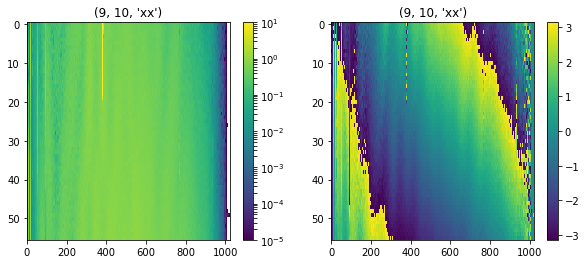

In [5]:
bl = (9,10,'xx')

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(np.abs(data.get_data(bl)), aspect='auto', norm=LogNorm(vmin=.00001, vmax=10))
plt.title(bl)
plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(data.get_data(bl)), aspect='auto')
plt.title(bl)
plt.colorbar()


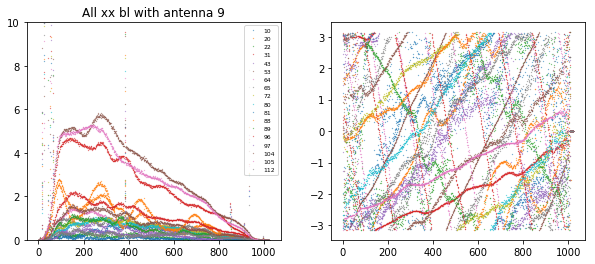

In [6]:
ants = data.get_ants()
ant1 = ants[0]
#bl = (ants[3],ants[6],'xx')
integration = 0
plt.figure(figsize=(10,4))
for ant2 in ants:
    if ant2 != ant1:
        bl = (ant1, ant2, 'xx')
        plt.subplot(121)
        plt.plot(np.abs(data.get_data(bl)[integration,:]), '.', ms=.5, label = ant2)
        plt.title('All ' + bl[2] + ' bl with antenna ' + str(ant1))
        plt.ylim([0,10])
        plt.legend(fontsize=6)
        plt.subplot(122)
        plt.plot(np.angle(data.get_data(bl)[integration,:]), '.', ms=.5)


# Print ant_metrics results

In [7]:
am = ant_metrics.load_antenna_metrics(ant_metrics_json)
print am['xants']
print am['crossed_ants']
print am['dead_ants']

[(22, 'y'), (22, 'x'), (81, 'y'), (81, 'x')]
[(22, 'y'), (22, 'x'), (81, 'y'), (81, 'x')]
[]


# Examine firstcal results

In [8]:
fc = UVCal()
fc.read_calfits(fcFileList)
fc_antpols = [aipy.miriad.pol2str[index][0] for index in fc.jones_array]
fc_delays = {}
for ip, antpol in enumerate(fc_antpols):
    for ia, ant in enumerate(fc.ant_array):
        fc_delays[(ant,antpol)] = fc.delay_array[ia,0,0,:,ip]

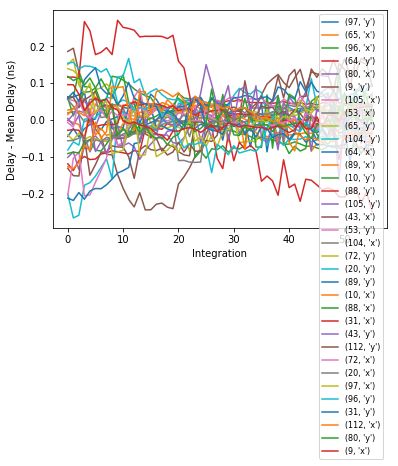

In [9]:
plt.figure()
for (ant,antpol), delays in fc_delays.items():
    plt.plot(1e9*(delays - np.mean(delays)), label=(ant,antpol))

plt.xlabel('Integration')
plt.ylabel('Delay - Mean Delay (ns)')
plt.legend(fontsize=8)

# Examine Omnical Solutions

In [10]:
oc = UVCal()
oc.read_calfits(omnicalFile)
oc_antpols = [aipy.miriad.pol2str[index][0] for index in oc.jones_array]
oc_gains = {}

for ip, antpol in enumerate(oc_antpols):
    for ia, ant in enumerate(oc.ant_array):
        oc_gains[(ant,antpol)] = oc.gain_array[ia,0,:,:,ip]

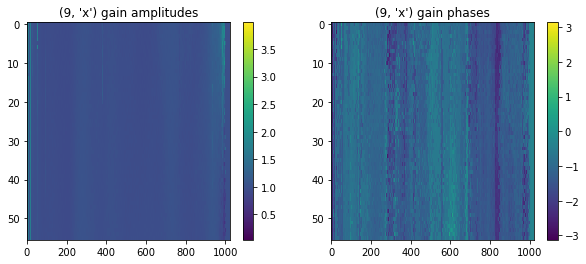

In [11]:
antenna = (ants[0],'x')

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(np.abs(oc_gains[antenna].T), aspect='auto')
plt.title(str(antenna) + ' gain amplitudes')
plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(oc_gains[antenna].T), aspect='auto')
plt.title(str(antenna) + ' gain phases')
plt.colorbar()

In [12]:
vis = UVData()
vis.read_uvfits(omniVisFile)

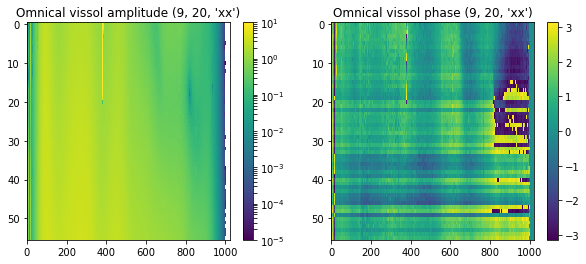

In [13]:
antpair = vis.get_antpairs()[0]
bl = (antpair[0],antpair[1],'xx')

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(np.abs(vis.get_data(bl)), aspect='auto', norm=LogNorm(vmin=.00001, vmax=10))
plt.title('Omnical vissol amplitude ' + str(bl))
plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(vis.get_data(bl)), aspect='auto')
plt.title('Omnical vissol phase ' + str(bl))
plt.colorbar()


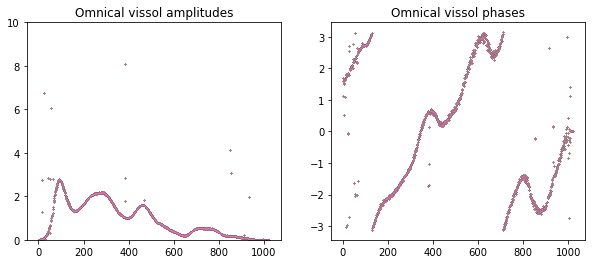

In [14]:
integration = 0
plt.figure(figsize=(10,4))
for (ant1, ant2) in vis.get_antpairs():
    ant1, ant2 = 9,20
    bl = (ant1, ant2, 'xx')
    plt.subplot(121)
    plt.plot(np.abs(vis.get_data(bl)[integration,:]), '.', ms=.5, label = bl)
    plt.title('Omnical vissol amplitudes')
    plt.ylim([1e-5,10])
#    plt.legend(fontsize=6)
    plt.subplot(122)
    plt.title('Omnical vissol phases')
    plt.plot(np.angle(data.get_data(bl)[integration,:]), '.', ms=.5)

# Perform Omnical Here

In [15]:
freqs = data.freq_array[0,:] / 1e9
aa = utils.get_aa_from_calfile(freqs[0], calfile)
ex_ants = list(set([ant[0] for ant in am['xants']]))
ex_ants.append(43)
print 'Manually removing antenna 43'
info = omni.aa_to_info(aa, pols=['x','y'], ex_ants=ex_ants)
#info = omni.aa_to_info(aa, pols=['x'], ex_ants=ex_ants) # this is for only running 1pol omnical
_, g0, _, _ = omni.from_fits(fcFileList) #check and see if this is the same as aaron
# also deal with antenna 43

Manually removing antenna 43
/lustre/aoc/projects/hera/zali/HERA2015/2457555/IDR3/zen.2457555.42443.xx.HH.uvc.first.calfits
/lustre/aoc/projects/hera/zali/HERA2015/2457555/IDR3/zen.2457555.42443.yy.HH.uvc.first.calfits


## Extract a single integration

In [16]:
datapack, wgtpack = firstcal.UVData_to_dict([data])
for bl in datapack.keys():
    for pol in datapack[bl].keys():
        datapack[bl][pol] = np.array(datapack[bl][pol][0:1,:], dtype=np.complex64)
for antpol in g0.keys():
    for ant in g0[antpol].keys():
        g0[antpol][ant] = np.array(g0[antpol][ant][0:1,:], dtype=np.complex64)        

## Run Omnical Regularly

In [17]:
m1, g1, v1 = omnical.calib.logcal(datapack, info, gains=g0)
m2, g2, v2 = omnical.calib.lincal(datapack, info, gains=g1, vis=v1)
g3, v3 = omni.remove_degen(info, g2, v2, g0, minV=False)

In [18]:
# np.linalg.norm(v3['xx'][9,20][0,:] - vis.get_data(9,20,'xx')[0,:]) / np.linalg.norm(v3['xx'][9,20][0,:])

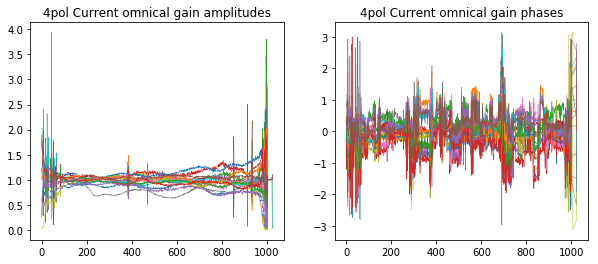

In [19]:
plt.figure(figsize=(10,4))
for ant in g3['x'].keys():
    plt.subplot(121)
    plt.plot(np.abs(g3['x'][ant][0,:] / g0['x'][ant][0,:]), '-', lw=.5)
    plt.title('4pol Current omnical gain amplitudes')
    plt.subplot(122)
    plt.title('4pol Current omnical gain phases')
    plt.plot(np.angle(g3['x'][ant][0,:] / g0['x'][ant][0,:]), '-', lw=.5)

## Now apply firstcal gains ahead of time

In [20]:
datapack_fc, wgtpack_fc = firstcal.UVData_to_dict([data])
for bl in datapack_fc.keys():
    if bl[0] not in ex_ants and bl[1] not in ex_ants:
        for pol in datapack_fc[bl].keys():
            datapack_fc[bl][pol] = datapack_fc[bl][pol][0:1,:] / (g0[pol[0]][bl[0]] * np.conj(g0[pol[1]][bl[1]]))
            datapack_fc[bl][pol] = np.array(datapack_fc[bl][pol], dtype=np.complex64)


In [21]:
unit_gains = deepcopy(g0)
for antpol in unit_gains.keys():
    for ant in unit_gains[antpol].keys():
        unit_gains[antpol][ant] = np.ones_like(unit_gains[antpol][ant])
        unit_gains[antpol][ant] = np.array(unit_gains[antpol][ant], dtype=np.complex64)

In [22]:
m1_fc, g1_fc, v1_fc = omnical.calib.logcal(datapack_fc, info, gains=unit_gains)
m2_fc, g2_fc, v2_fc = omnical.calib.lincal(datapack_fc, info, gains=g1_fc, vis=v1_fc)
g3_fc, v3_fc = omni.remove_degen(info, g2_fc, v2_fc, unit_gains, minV=False)

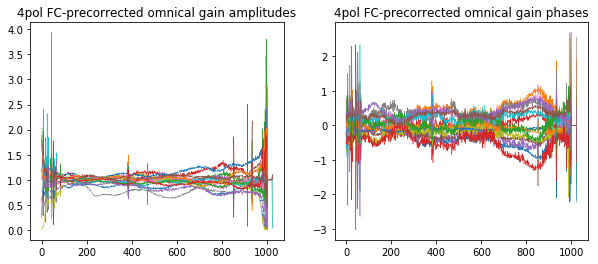

In [23]:
plt.figure(figsize=(10,4))
for ant in g3_fc['x'].keys():
    plt.subplot(121)
    plt.plot(np.abs(g3_fc['x'][ant][0,:]), '-', lw=.5)
    plt.title('4pol FC-precorrected omnical gain amplitudes')
    plt.subplot(122)
    plt.title('4pol FC-precorrected omnical gain phases')
    plt.plot(np.angle(g3_fc['x'][ant][0,:]), '-', lw=.5)